In [1]:
import tensorflow as tf
import numpy as np
import os
import copy
import sklearn.cluster
from munkres import Munkres
import scipy.io as sio
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0: all messages are logged (default), 1: INFO messages are not printed, 2: INFO and WARNING messages are not printed, 3: ERROR messages are not printed
tf.get_logger().setLevel('ERROR')

tf.compat.v1.disable_eager_execution()
def train_Deep_network(missing_data_num):
	class ConvAE(object):
		def __init__(self, input_shape,flat_layer_size,auto_layer_size,deco_layer_size,  reg_const1 = 1.0, reg_const2 = 1.0, reg = None, batch_size = 200,\
			model_path = None, logs_path = 'E:\MS\Semester\Summer\RA\Synthetic Data\logs'):	

			self.input_shape = input_shape
			self.n_features = input_shape[1]
			self.model_path = model_path			
			self.iter = 0
			self.batch_size = batch_size

			self.flat_layer_size = flat_layer_size
			self.auto_layer_size = auto_layer_size
			self.deco_layer_size = deco_layer_size

			# model
			self.x = tf.compat.v1.placeholder(tf.float32, [None, self.n_features],name= "Input_data")
			self.learning_rate = tf.compat.v1.placeholder(tf.float32, [], name = "learning_rate")
			

			self.encoded = self.encoder(self.x)
			self.z_ssc, Coef = self.selfexpressive_module()	
			self.Coef = Coef						
			self.decoded = self.decoder(self.z_ssc)		
			

			self.saver = tf.compat.v1.train.Saver()
			
			with tf.name_scope("Loss") as scope:
				
				# Loss with X_omega and X_omega_hat
				self.x_omega, self.mask_tensor = convert_nan(self.x)
				self.x_omega_hat = self.decoded * self.mask_tensor
				self.reconstruction_cost =  0.5*tf.norm(tf.subtract(self.x_omega_hat, self.x_omega), ord='fro',axis=(0,1))

				# Loss with full data
				# self.reconstruction_cost =  0.5*tf.norm(tf.subtract(self.decoded, self.x),ord='fro',axis=(0,1))
				self.latent_cost = 0.5 * tf.norm(tf.subtract(self.encoded, self.z_ssc),ord='fro',axis=(0,1))
				self.coefficient_ssc = tf.norm(self.Coef,ord=2,axis=(0,1))			
				self.loss_ssc = self.latent_cost * reg_const2 + reg_const1 * self.coefficient_ssc + self.reconstruction_cost
				# self.loss_ssc = reg_const1 * self.coefficient_ssc + self.reconstruction_cost

				# Adding the losses to logs
				tf.compat.v1.summary.scalar("Self_expressive_Loss", self.latent_cost)
				tf.compat.v1.summary.scalar("Coefficient_Loss", self.coefficient_ssc)
				tf.compat.v1.summary.scalar("Reconstruction_Loss", self.reconstruction_cost) 
				tf.compat.v1.summary.scalar("Total_Loss", self.loss_ssc) 

			autoencoder_variables = tf.compat.v1.trainable_variables()
			for var in autoencoder_variables:
				tf.compat.v1.summary.histogram(var.name, var)
				
			self.merged_summary_op = tf.compat.v1.summary.merge_all()		
			self.optimizer_ssc = tf.compat.v1.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.loss_ssc)

			self.init = tf.compat.v1.global_variables_initializer()
			self.sess = tf.compat.v1.InteractiveSession()
			self.sess.run(self.init)
			self.summary_writer = tf.compat.v1.summary.FileWriter(logs_path, graph=tf.compat.v1.get_default_graph())

		# Building the encoder
		# Building the encoder
		def encoder(self,x):

			with tf.name_scope("Flat_Flayer") as scope:
					
				stacked_tensors_list = []
				for i in range(0,self.input_shape[1]):
					input_flat = tf.reshape(x[:,i],[1,self.flat_layer_size[0]])
					input_missing_flat , mask_flat_tensor = convert_nan(input_flat)
					flat_layer_output = tf.compat.v1.layers.dense(input_missing_flat, self.input_shape[0], activation=tf.nn.relu, name="flattened_layer_"+str(i + 1),kernel_initializer=None,bias_initializer=tf.compat.v1.zeros_initializer())

					stacked_tensors_list.append(tf.transpose(flat_layer_output))
				
				stacked_flat_tensor = tf.concat(stacked_tensors_list, axis=1)
		
			with tf.name_scope("Encoder") as scope:
				encoder_layer = stacked_flat_tensor
				for i in range(0,len(self.auto_layer_size)):
					encoder_layer = tf.compat.v1.layers.dense(encoder_layer, self.auto_layer_size[i], activation=tf.nn.relu, name="encoder_layer_"+str(i + 1),kernel_initializer=None,bias_initializer=tf.compat.v1.zeros_initializer())

				return  encoder_layer

		# Building the decoder
		def decoder(self,z):
			with tf.name_scope("Decoder") as scope:
				decoder_layer = z

				for i in range(0,len(self.deco_layer_size)):
					decoder_layer = tf.compat.v1.layers.dense(decoder_layer, self.deco_layer_size[i], activation=tf.nn.relu, name="decoder_layer_"+str(i + 1),kernel_initializer=None,bias_initializer=tf.compat.v1.zeros_initializer())

			return decoder_layer

		#Building the Self-Expressive Layer
		def selfexpressive_module(self):
			with tf.name_scope("Self-Expressive_Layer") as scope:
				Coef = tf.Variable(1.0e-4 * tf.ones([self.batch_size, self.batch_size],tf.float32), name = 'Coef')			
				z_ssc = tf.matmul(Coef,	self.encoded)

				return z_ssc, Coef


		def finetune_fit(self, X, lr):
			C, cost, complete_data, summary, _ = self.sess.run((self.Coef, self.reconstruction_cost, self.decoded , self.merged_summary_op, self.optimizer_ssc), feed_dict = {self.x: X, self.learning_rate: lr})
			self.summary_writer.add_summary(summary, self.iter)
			self.iter = self.iter + 1
			return C, cost, complete_data
		
		def initlization(self):
			self.sess.run(self.init)	

		def close_session(self):
			self.sess.close()

	def best_map(L1,L2):
	#L1 should be the labels and L2 should be the clustering number we got
		Label1 = np.unique(L1)
		nClass1 = len(Label1)
		Label2 = np.unique(L2)
		nClass2 = len(Label2)
		nClass = np.maximum(nClass1,nClass2)
		G = np.zeros((nClass,nClass))
		for i in range(nClass1):
			ind_cla1 = L1 == Label1[i]
			ind_cla1 = ind_cla1.astype(float)
			for j in range(nClass2):
				ind_cla2 = L2 == Label2[j]
				ind_cla2 = ind_cla2.astype(float)
				G[i,j] = np.sum(ind_cla2 * ind_cla1)

		m = Munkres()
		index = m.compute(-G.T)
		index = np.array(index)
		c = index[:,1]
		newL2 = np.zeros(L2.shape)
		for i in range(nClass2):
			newL2[L2 == Label2[i]] = Label1[c[i]]
		return newL2

	def thrC(C,ro):
		if ro < 1:
			N = C.shape[1]
			Cp = np.zeros((N,N))
			S = np.abs(np.sort(-np.abs(C),axis=0))
			Ind = np.argsort(-np.abs(C),axis=0)
			for i in range(N):
				cL1 = np.sum(S[:,i]).astype(float)
				stop = False
				csum = 0
				t = 0
				while(stop == False):
					csum = csum + S[t,i]
					if csum > ro*cL1:
						stop = True
						Cp[Ind[0:t+1,i],i] = C[Ind[0:t+1,i],i]
					t = t + 1
		else:
			Cp = C

		return Cp

	def post_proC(C, K, d, alpha):
		# C: coefficient matrix, K: number of clusters, d: dimension of each subspace
		C = 0.5*(C + C.T)
		r = d*K + 1	
		U, S, _ = svds(C,r,v0 = np.ones(C.shape[0]))
		U = U[:,::-1] 
		S = np.sqrt(S[::-1])
		S = np.diag(S)
		U = U.dot(S)
		U = normalize(U, norm='l2', axis = 1)  
		Z = U.dot(U.T)
		Z = Z * (Z>0)
		L = np.abs(Z ** alpha)
		L = L/L.max()
		L = 0.5 * (L + L.T)	
		spectral = sklearn.cluster.SpectralClustering(n_clusters=K, eigen_solver='arpack', affinity='precomputed',assign_labels='discretize')
		spectral.fit(L)
		grp = spectral.fit_predict(L) + 1 
		return grp, L

	def err_rate(gt_s, s):
		c_x = best_map(gt_s,s)
		err_x = np.sum(gt_s[:] != c_x[:])
		missrate = err_x.astype(float) / (gt_s.shape[0])
		# print(sklearn.metrics.confusion_matrix(gt_s, c_x))
		return missrate 

	# main function starts here
	if __name__ == '__main__':
			
		with open('E:\MS\Semester\Summer\RA\Synthetic Data\syndata200x50.csv', 'r') as f: 
			data = np.genfromtxt(f, dtype='f4', delimiter=',')

		full_data = copy.deepcopy(data) # Deep copy of full data
		input_shape = np.shape(data)
		batch_size = input_shape[0] # Total number of Samples

		# Model Architecture
		flat_layer_size = [input_shape[0]] # Flat Layer Neurons Size
		auto_layer_size = [40] # Encoder Layer Neurons Size (Add multiple for more layers)
		deco_layer_size = [50] # Decoder Layer Neurons Size (Add multiple for more layers)

		logs_path = 'E:\MS\Semester\Summer\RA\Synthetic Data\logs'

		# Learning Parameters
		epoch = 300

		#Learning Rate
		start_value = 1e-2 
		end_value = 0.5e-3
		num_points = 6
		learning_rate_skip = int(epoch/num_points)
		exponential_learning_rate = np.geomspace(start_value, end_value, num_points)

		reg1 = 1.0 # regularization constant for Coefficient Loss
		reg2 = 0.01 # regularization constant for Self-Expressive Loss
		alpha = 0.1 #max(0.4 - (num_class-1)/10 * 0.1, 0.1)
		num_class = 4 

		
		labels = []
		for j in range(1,5):
			perc_num_list = [j for i in range(0,50)] 
			labels.append(perc_num_list)
		labels = np.array(labels)
		true_labels = labels.flatten()

		def convert_nan(input): # Function to create a Mask tensor with 1s in available data and zero in missing data
			nan_mask = tf.math.is_nan(input)
			x_omega = tf.where(nan_mask, tf.zeros_like(input), input)
			mask_tensor = tf.where(nan_mask, tf.zeros_like(input), tf.ones_like(input))
			return x_omega, mask_tensor
		
		def convert_nan_reverse(input): # Function to create a Mask tensor with 1s in missing data and zero in available data 
			nan_mask = tf.math.is_nan(input)
			x_omega = tf.where(nan_mask, tf.zeros_like(input), input)
			mask_tensor = tf.where(nan_mask, tf.ones_like(input),tf.zeros_like(input))
			return x_omega, mask_tensor

		def missing_data_generation(input,num_nans): # Function to create random Nan values 
			# num_nans: Choose the desired number of NaN values
			indices = np.random.choice(input.size, size=num_nans, replace=False)
			input.ravel()[indices] = np.nan
			return input

		tf.compat.v1.reset_default_graph()
		missing_data_input = missing_data_generation(data,missing_data_num)
		CAE = ConvAE( input_shape, flat_layer_size,auto_layer_size,deco_layer_size, reg_const1 = reg1, reg_const2 = reg2, reg = None, batch_size = 200,\
				model_path = None, logs_path = logs_path)

		data_norm = tf.norm(full_data,ord='fro',axis=(0,1)).eval() # Frobenius norm of full data
		CAE.initlization()
		for iter_ft  in range(epoch):
			if (iter_ft % learning_rate_skip == 0):
				learning_rate = exponential_learning_rate[int(iter_ft/learning_rate_skip)]
			C, cost, complete_data = CAE.finetune_fit(missing_data_input,learning_rate)
			accuracy = tf.norm(tf.subtract(complete_data, full_data),ord='fro',axis=(0,1)).eval()/data_norm
			if ((iter_ft+1) % 300 == 0): # and (iter_ft >= 50):
				# C = thrC(C,alpha)			
				y_x, CKSym_x = post_proC(C, num_class, 3 , 4)			
				missrate_x = err_rate(true_labels,y_x)			
				cluster_acc = 1 - missrate_x
		CAE.close_session()

		return (1-accuracy)*100, cluster_acc*100
		


In [2]:
missing_num_list = [i for i in range(0,10000,500)]
accuracy_list = []
cluster_accuracy_list = []
for missing_num in missing_num_list:
	accuracy, cluster_accuracy = train_Deep_network(missing_num)
	accuracy_list.append(accuracy)
	cluster_accuracy_list.append(cluster_accuracy)
	print ("Number of missing Points: %.1d ::" % missing_num, "Accuracy: %.2f ::" %  accuracy, "Cluster Accuracy: %.2f" % cluster_accuracy)


Number of missing Points: 0 :: Accuracy: 99.84 :: Cluster Accuracy: 90.00
Number of missing Points: 500 :: Accuracy: 99.66 :: Cluster Accuracy: 91.00
Number of missing Points: 1000 :: Accuracy: 98.70 :: Cluster Accuracy: 96.50
Number of missing Points: 1500 :: Accuracy: 98.70 :: Cluster Accuracy: 94.00
Number of missing Points: 2000 :: Accuracy: 98.47 :: Cluster Accuracy: 96.00
Number of missing Points: 2500 :: Accuracy: 95.89 :: Cluster Accuracy: 92.00
Number of missing Points: 3000 :: Accuracy: 93.86 :: Cluster Accuracy: 96.00
Number of missing Points: 3500 :: Accuracy: 89.66 :: Cluster Accuracy: 95.50


In [ ]:
# cluster_accuracy_list[0] = 97.0 #0
# cluster_accuracy_list[1] = 97.0 #500
# cluster_accuracy_list[2] = 96.0 #1000
# cluster_accuracy_list[3] = 97.5 #1500
# cluster_accuracy_list[4] = 97.5 #1500
# cluster_accuracy_list[11] = 84.5 #1500
# cluster_accuracy_list[12] = 65 #1500




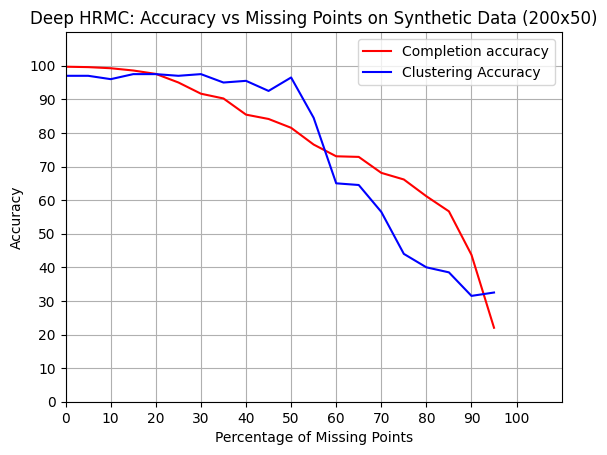

In [ ]:
perc_num_list = [int(i/100) for i in range(0,10000,500)]
plt.plot(perc_num_list, accuracy_list, c='r', label = "Completion Accuracy")
plt.plot(perc_num_list, cluster_accuracy_list, c='b', label = 'Clustering Accuracy')
plt.legend(["Completion accuracy", "Clustering Accuracy"])
plt.title("Deep HRMC: Accuracy vs Missing Points on Synthetic Data (200x50)")
plt.xlabel('Percentage of Missing Points')
plt.ylabel('Accuracy')
plt.ylim(0,110)
plt.xlim(0,110)
plt.yticks(range(0, 101, 10))
plt.xticks(range(0, 101, 10))
plt.grid()
plt.show()
